# Big Data Analysis and Its Application (Hadoop or Spark)
## 李乐平 12112627

### Answer to Question 1

In [29]:
import pyspark

from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType

import pyspark.sql.functions as F

from pyspark.sql.functions import col, sum, date_format, to_timestamp, length

from functools import reduce

In [2]:
# Define the required schema

my_schema = StructType([
    StructField("InvoiceNo", IntegerType(), True),
    StructField("StockCode", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Quantity", IntegerType(), True),
    StructField("InvoiceDate", StringType(), True),
    StructField("UnitPrice", DoubleType(), True),
    StructField("CustomerID", IntegerType(), True),
    StructField("Country", StringType(), True),
])

In [3]:
# Read the .csv file

spark = SparkSession.builder.config('spark.ui.port', 14040).appName("pyspark SQL basic example").getOrCreate()

df = spark.read.option("header", "true") \
               .option("dateFormat", "M/d/yyyy H:mm") \
               .schema(my_schema)\
               .csv("./hw01/Q1_data/retail-dataset.csv")

print(df.count())
df.show()
df.printSchema()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/06 15:06:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/03/06 15:06:08 WARN Utils: Service 'SparkUI' could not bind on port 14040. Attempting port 14041.


541909
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|12/1/2010 8:26|     7.65|     17850|United Kingdom|
|   536365|    21730|GLASS STAR FROSTE...|       6|12/1/2010 8:26|

In [4]:
# Remove the missing and the illegal data

df = df.dropna()[(df["UnitPrice"] > 0) & (df["Quantity"] > 0)]
print(df.count())
df.show()

397884
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|12/1/2010 8:26|     7.65|     17850|United Kingdom|
|   536365|    21730|GLASS STAR FROSTE...|       6|12/1/2010 8:26|

In [5]:
# Calculate the total revenue

df_with_revenue = df.withColumn("Revenue", col("Quantity") * col("UnitPrice"))
total_revenue = df_with_revenue.agg({"Revenue": "sum"}).collect()[0][0]
print(f"Total revenue of all countries: {total_revenue}")

Total revenue of all countries: 8911407.904000023


In [6]:
# Calculate and sort out the top 5 customers who spent most

df_cust = df_with_revenue.groupBy("CustomerID").agg(sum("Revenue").alias("Revenue"))
df_cust.orderBy("Revenue", ascending=False).limit(5).show()

+----------+------------------+
|CustomerID|           Revenue|
+----------+------------------+
|     14646|280206.01999999996|
|     18102|259657.29999999996|
|     17450|194550.78999999998|
|     16446|          168472.5|
|     14911|143825.06000000003|
+----------+------------------+



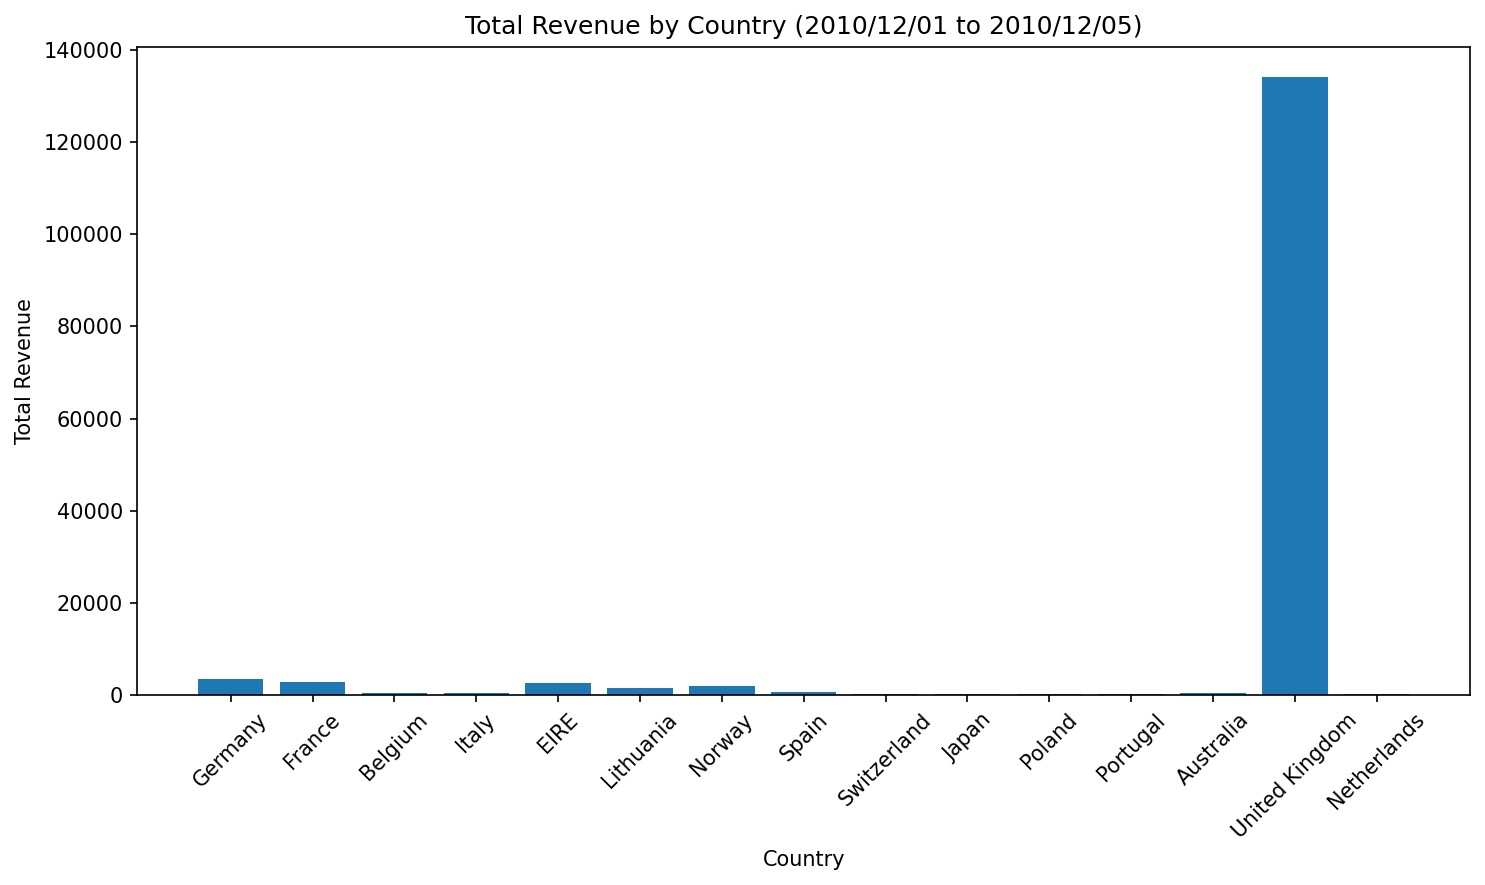

In [18]:
# Filter out the records between Dec 1st, 2010 and Dec 5th, 2010

import matplotlib.pyplot as plt
df_country = df_with_revenue.withColumn("TimeStamp", to_timestamp("InvoiceDate", "M/d/yyyy H:mm"))
df_country = df_country[(df_country["Timestamp"] >= "2010-12-01 00:00:00") & (df_country["Timestamp"] <= "2010-12-05 23:59:59")]
df_country = df_country.groupBy("Country").agg(sum("Revenue").alias("Revenue"))

df_country_pd = df_country.toPandas()

# Draw the plot

plt.figure(figsize=(10, 6), dpi = 150)
plt.bar(df_country_pd["Country"], df_country_pd["Revenue"])
plt.xlabel("Country")
plt.ylabel("Total Revenue")
plt.title("Total Revenue by Country (2010/12/01 to 2010/12/05)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Answer to Question 2.1

In [20]:
import os
import csv

folder_path = "./hw01/Q2_data/"

# First deal with the format of the .csv files so that they could be correctly parsed

csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv') and not file.endswith("-truncated.csv")]

for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    output_file_path = os.path.join(folder_path, f"{os.path.splitext(file_name)[0]}-truncated.csv")
    with open(file_path, 'r', newline='') as csvfile:
        data = list(csv.reader(csvfile))
    with open(output_file_path, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerows(data[1:])

In [28]:
# Read the .csv files

truncated_csv_files = [file for file in os.listdir(folder_path) if file.endswith("-truncated.csv")]

dfs = [
    spark.read.option("header", "true") \
    .csv(os.path.join(folder_path, file)) \
    .select("sequence_alignment_aa", "cdr1_aa", "cdr2_aa", "cdr3_aa") \
    for file in truncated_csv_files
]

# Remove the illegal records

df2 = reduce(lambda df1, df2: df1.union(df2), dfs)
df2 = df2.filter((length("cdr3_aa") >= 10) & (length("cdr3_aa") <= 100))

df2.show()

+---------------------+---------+-------+------------+
|sequence_alignment_aa|  cdr1_aa|cdr2_aa|     cdr3_aa|
+---------------------+---------+-------+------------+
| QSVLTQPPSASGTPGQR...| SSNIGSDT|    SNN| AAWDDSLNGWV|
| QSMLTQPPSASGTPGQR...| NSNIGSNT|    SSN|ASWDDGLDGFVI|
| QSMLTQPPSASGTPEQR...| NSNIGSNT|    SSN|ASWDDGLDGFVI|
| GVPDRFSGSKSGTSASL...|     NULL|   NULL| QSYDNSLSVWV|
| GVPDRFSGSTSGTSASL...|     NULL|   NULL|QSFDNSLGGFYV|
| QSALTQPPSASGTPGQR...| RSNIGINT|    SND| DAWDDNLNGPV|
| QSALTQPASMSGSPGQS...|SSDVGASNH|    EVS|  YSYAVGVTFV|
| TLSLTCGSSTGAVHSGY...|TGAVHSGYY|    STD|LLYFGGIQPLWV|
| EIVMTQSPATLSVSPGE...|   QSVSSN|    GTS|  HQYNSWPPGT|
| DIQMTQSPSSLSASVGD...|   QSISSY|    AAS|  QQSYSTHPYT|
| EIVMTQSPATLSVSPGE...|   QSVSSN|    GAS|  QQYNNWPPWT|
| EIVLAQSPATLSLSPGE...|   QSVSSY|    DAS|  QQRNNWPPYT|
| DIVLTQSPGTLSLSPGE...|  HSINRRF|    GTS|  QQYDTSQGYP|
| DIVLTQSPGTLSLSPGE...|  QRVNTKY|    GAY|  QLYGPSQGYP|
| EIVMTQSPATLSVSPGE...|   QSVGTN|    GAS|  HQHKDWPRGA|
| EIVLTQSP

In [32]:
df2.coalesce(1).write.option("header", "true").csv("./Q2_1.csv")